In [1]:
from transformers import pipeline

import json
import pandas as pd
import numpy as np
from scipy.stats import mode
from sklearn.model_selection import train_test_split

2023-05-09 20:19:07.763794: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 20:19:08.216295: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Fetch data using arxiv api

In [2]:
import arxiv
from multiprocessing.pool import ThreadPool

In [3]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def get_using_api(chunk):
    try:
        ret = list(arxiv.Search(id_list=chunk).results())
    except:
        ret = []
    return ret

In [4]:
# json_path = 'arxivData.json'
# with open(json_path) as f:
#     json_data = json.loads(f.read())

# ids = [t['id'] for t in json_data]
# fetched_data = []
# for res in ThreadPool(30).map(get_using_api, chunks(ids, 100), total=len(ids)//100):
#     fetched_data.extend(res)

In [5]:
# import pickle

# with open('papers_info.pickle', 'wb+') as f:
#     pickle.dump(fetched_data, f)


## sth

In [2]:
import pickle

with open('papers_info.pickle', 'rb') as f:
    fetched_data = pickle.load(f)

In [3]:
tags_change = [
    (set(['quant-ph', 'physics', 'nucl-th', 'nucl-ex', 'nlin', 'math-ph', 'hep-th', 'hep-ph', 'hep-lat', 'hep-ex', 'gr-qc', 'cond-mat', 'astro-ph', 'adap-org']),
        'physics'),
    (['cmp-lg'], 'cs'),
]


tags_names = {
    'cs': 'Computer Science',
    'econ': 'Economics',
    'eess': 'Electrical Engineering and Systems Science',
    'math': 'Mathematics',
    'q-bio': 'Quantitative Biology',
    'q-fin': 'Quantitative Finance',
    'stat': 'Statistics',
    'physics': 'Physics'
}

tag_to_y = dict(zip(tags_names, range(len(tags_names))))

def tag_to_cat(tag):
    # returns tag category as number / -1 if unkown
    tag = tag.split('.')[0]
    for tags, new_name in tags_change:
        if tag in tags:
            tag = new_name
            break
    if tag not in tag_to_y:
        print(tag, end=' ')
    return tag_to_y.get(tag, -1)

In [8]:
MIN_PAPERS_NUM = 100

data = pd.DataFrame([{'title': paper.title,
                      'summary': paper.summary,
                      'category': tag_to_cat(paper.primary_category)} for paper in fetched_data])

counts = data.category.value_counts()
too_few = counts[counts < MIN_PAPERS_NUM].index
data = data.query(f'category != -1 and category not in {list(too_few)}')
counts.index = np.array(list(tags_names))[counts.index]
counts

cs         34705
stat        4781
math         612
physics      469
q-bio        320
eess          78
q-fin         30
econ           5
Name: count, dtype: int64

## data prep

In [14]:
tokenizer.batch_encode_plus?

Signature:
tokenizer.batch_encode_plus(
    batch_text_or_text_pairs: Union[List[str], List[Tuple[str, str]], List[List[str]], List[Tuple[List[str], List[str]]], List[List[int]], List[Tuple[List[int], List[int]]]],
    add_special_tokens: bool = True,
    padding: Union[bool, str, transformers.utils.generic.PaddingStrategy] = False,
    truncation: Union[bool, str, transformers.tokenization_utils_base.TruncationStrategy] = None,
    max_length: Optional[int] = None,
    stride: int = 0,
    is_split_into_words: bool = False,
    pad_to_multiple_of: Optional[int] = None,
    return_tensors: Union[str, transformers.utils.generic.TensorType, NoneType] = None,
    return_token_type_ids: Optional[bool] = None,
    return_attention_mask: Optional[bool] = None,
    return_overflowing_tokens: bool = False,
    return_special_tokens_mask: bool = False,
    return_offsets_mapping: bool = False,
    return_length: bool = False,
    verbose: bool = True,
    **kwargs,
) -> transformers.tokenizatio

In [17]:
import tensorflow as tf
from math import ceil

MAX_LENGTH = 290

def batch_encode(tokenizer, texts, y, return_tensors='tf', batch_size=256, max_length=MAX_LENGTH):
    # return list of (input_ids, attention_mask)
    encoded = []
    ys = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        ys.append(y[i:i+batch_size])
        
        inputs = tokenizer.batch_encode_plus(
            batch,
            max_length=max_length,
            padding='longest',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors=return_tensors
        )
        
        encoded.append([inputs['input_ids'], inputs['attention_mask']])
    
    return encoded, ys

class MySequence(tf.keras.utils.Sequence):
    def __init__(self, tokenizer, X, y, batch_size=256) -> None:
        super().__init__()
        # self.X, self.y = batch_encode(tokenizer, X, y.values, batch_size)
        self.X = X
        self.y = y.values
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.max_length = MAX_LENGTH

    def __len__(self):
        return ceil(len(self.X) / (self.batch_size*10))

    def __getitem__(self, idx):
        sl = slice(idx * self.batch_size, (idx + 1) * self.batch_size)
        batch = self.X[sl]
        
        inputs = tokenizer.batch_encode_plus(
            batch,
            max_length=self.max_length,
            padding='longest',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False
        )
        
        return list(map(
            tf.convert_to_tensor,
            [inputs['input_ids'], inputs['attention_mask']]
        )), self.y[sl]

In [13]:
from transformers import DistilBertTokenizerFast

# Instantiate DistilBERT tokenizer...we use the Fast version to optimize runtime
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

from imblearn.over_sampling import RandomOverSampler

train_data, val_data = train_test_split(data, test_size=.1, stratify=data.category)

def oversample_and_shuffle(df):
    balanced, _ = RandomOverSampler().fit_resample(df, df.category)
    shuffled_indices = np.arange(len(balanced))
    np.random.shuffle(shuffled_indices)
    return balanced.iloc[shuffled_indices]

balanced_train, balanced_test = map(oversample_and_shuffle, [train_data, val_data])
X_train, y_train = balanced_train[['title', 'summary']], balanced_train.category
X_val, y_val = balanced_test[['title', 'summary']], balanced_test.category

In [18]:
train_seq = MySequence(tokenizer, X_train.summary.to_list(), y_train)

val_seq = MySequence(tokenizer, X_val.summary.to_list(), y_val)

In [13]:
from imblearn.over_sampling import RandomOverSampler

from transformers import DistilBertTokenizer, DistilBertConfig, TFDistilBertModel

DISTILBERT_DROPOUT = 0.2
DISTILBERT_ATT_DROPOUT = 0.2
 
# Configure DistilBERT's initialization
config = DistilBertConfig(dropout=DISTILBERT_DROPOUT, 
                          attention_dropout=DISTILBERT_ATT_DROPOUT, 
                          output_hidden_states=True)
                          
# The bare, pre-trained DistilBERT transformer model outputting raw hidden-states 
# and without any specific head on top.
distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

# Make DistilBERT layers untrainable
# for layer in distilBERT.layers:
#     layer.trainable = False

2023-05-09 07:36:39.771373: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9601 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:07:00.0, compute capability: 8.6
2023-05-09 07:36:40.402764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly i

558
33


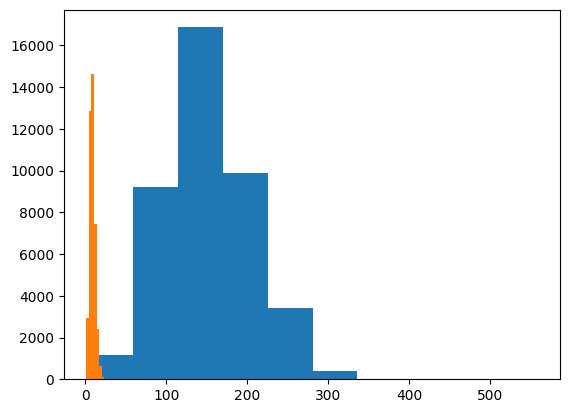

In [10]:
import matplotlib.pyplot as plt
lengths = [len(data.summary.split()) for data in fetched_data]
plt.hist(lengths)
print(max(lengths))

lengths = [len(data.title.split()) for data in fetched_data]
plt.hist(lengths)
print(max(lengths))

In [14]:
from functools import reduce

def chain(*funcs):
    # funcs: f1, f2, f3 -> lambda x: f1(f2(f3(x)))
    return lambda initial: reduce(lambda arg, f: f(arg), funcs[::-1], initial)

In [15]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

LAYER_DROPOUT = 0.2
LEARNING_RATE = 5e-5
RANDOM_STATE = 42

def build_model(transformer, max_length=MAX_LENGTH):
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=RANDOM_STATE) 

    input_ids_layer = tf.keras.layers.Input(
        shape=(None,), 
        name='input_ids', 
        dtype='int32'
    )
    input_attention_layer = tf.keras.layers.Input(
        shape=(None,), 
        name='input_attention', 
        dtype='int32'
    )
    
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    cls_token = last_hidden_state[:, 0, :]
    
    # net = tf.keras.layers.Dense(
    #     1024, 
    #     activation='relu',
    #     kernel_initializer=weight_initializer,  
    #     kernel_constraint=None,
    #     bias_initializer='zeros'
    # )(cls_token)
    
    # net = tf.keras.layers.Dropout(0.1)(net)

    
    output = tf.keras.layers.Dense(
        len(tags_names), 
        activation=None,
        kernel_initializer=weight_initializer,  
        kernel_constraint=None,
        bias_initializer='zeros'
    )(cls_token)
    
    # Define the model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    # Compile the model
    model.compile(tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
                  loss=SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    return model

In [21]:
model = build_model(distilBERT)
EPOCHS = 10

train_history1 = model.fit(
    x = train_seq,
    # steps_per_epoch=20,
    batch_size=1,
    epochs = EPOCHS,
    # validation_data = val_seq,
    verbose=1
)

Epoch 1/10


2023-05-09 07:44:38.296483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-09 07:44:53.755912: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 870.00MiB (rounded to 912261120)requested by op model_2/tf_distil_bert_model/distilbert/transformer/layer_._0/ffn/Gelu/mul_1
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-05-09 07:44:53.755943: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-05-09 07:44:53.755950: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total C

ResourceExhaustedError: Graph execution error:

Detected at node 'model_2/tf_distil_bert_model/distilbert/transformer/layer_._0/ffn/Gelu/mul_1' defined at (most recent call last):
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_52690/4185574555.py", line 4, in <module>
      train_history1 = model.fit(
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 558, in run_call_with_unpacked_inputs
      else:
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py", line 559, in call
      outputs = self.distilbert(
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 558, in run_call_with_unpacked_inputs
      else:
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py", line 410, in call
      tfmr_output = self.transformer(
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py", line 322, in call
      for i, layer_module in enumerate(self.layer):
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py", line 326, in call
      layer_outputs = layer_module(hidden_state, attn_mask, head_mask[i], output_attentions, training=training)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py", line 283, in call
      ffn_output = self.ffn(sa_output, training=training)  # (bs, seq_length, dim)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py", line 237, in call
      x = self.activation(x)
    File "/home/photon/anaconda3/envs/ML2_tf/lib/python3.10/site-packages/keras/activations.py", line 359, in gelu
      return tf.nn.gelu(x, approximate)
Node: 'model_2/tf_distil_bert_model/distilbert/transformer/layer_._0/ffn/Gelu/mul_1'
failed to allocate memory
	 [[{{node model_2/tf_distil_bert_model/distilbert/transformer/layer_._0/ffn/Gelu/mul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_53452]

In [25]:
output.last_hidden_state

<tf.Tensor: shape=(1, 12, 768), dtype=float32, numpy=
array([[[ 5.62806614e-04, -2.62099117e-01, -1.01467617e-01, ...,
         -6.27849102e-02,  2.75541157e-01,  3.69766146e-01],
        [ 7.22585201e-01,  1.64361268e-01,  4.00156379e-01, ...,
          1.91582590e-01,  4.04533803e-01, -5.84614202e-02],
        [ 2.82508910e-01, -1.74142480e-01,  3.91453132e-02, ...,
          2.76947767e-02,  1.19041234e-01,  9.14116025e-01],
        ...,
        [ 6.81020856e-01,  7.94044361e-02,  8.35899234e-01, ...,
         -4.89973962e-01, -2.49716908e-01, -2.35193565e-01],
        [ 3.82449105e-02, -8.17877352e-01, -3.40342104e-01, ...,
          4.47856784e-01,  9.73695964e-02, -2.03635693e-01],
        [ 3.59590352e-01,  2.00125724e-01,  1.73032403e-01, ...,
          1.51020110e-01, -2.36788750e-01,  5.37734702e-02]]],
      dtype=float32)>